# Statistical game result prediction
### Denisov Ilia

In [266]:
import numpy as np
import pylab as pl
import pandas as pd
from datetime import datetime as dt
from collections import Counter
import matplotlib.mlab as mlab
import seaborn as sns
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.metrics.pairwise import pairwise_distances
import scipy as sp
import random
import scipy.stats
from collections import defaultdict

np.set_printoptions(precision=2, threshold=5)
%pylab inline

Populating the interactive namespace from numpy and matplotlib


/home/denilv/anaconda3/lib/python3.6/site-packages/IPython/core/magics/pylab.py:161: UserWarning: pylab import has clobbered these variables: ['random', 'f']
`%matplotlib` prevents importing * from pylab and numpy
  "\n`%matplotlib` prevents importing * from pylab and numpy"


In [393]:
df_raw = pd.read_csv('seeds/inputs.csv')
df_raw = df_raw.fillna(0)
df = df_raw.iloc[::2]
df = df.reset_index()
delete_columns = ['week', 'game_id', 'season', 'index', 'team_org', 'opponent_team_org']
df = df.drop(delete_columns, axis=1)

dates = np.array(df.date)
dates = [dt.strptime(str(i), '%Y%m%d').date() for i in dates]

#add time
hours = []
for i in df.time:
    if i[-1] == 'p':
        hours.append(12+int(i.split(':')[0]))
    else:
        hours.append(int(i.split(':')[0]))
df.insert(1, 'hour', hours)

#add week day
weekdays = [i.weekday() for i in dates]
df.insert(1, 'weekday', weekdays)

#add weeknums
weeknums = [i.isocalendar()[1] for i in dates]
df.insert(1, 'week', weeknums)

#add win/lose
winloses = [1 if i>0 else 0 for i in df.points_difference]
df.insert(1, 'winlose', winloses)
df.drop('win_against_spread', axis=1)

#add seasons
seasons = [i.year for i in dates]
df.insert(1, 'year', seasons)

df.total_team = df.total_opponent

df = df.drop(['date', 'time'], axis=1)
df_old = df.copy()
print(len(df))
df.head()

5676


,year,winlose,week,weekday,hour,team,opponent_team,points,opponent_points,points_difference,spread,win_against_spread,spread_percentage_sbr,moneyline_team,moneyline_opponent,total_team,total_opponent,spread_percentage_sportsplays,spread_percentage_vegas
0,2013,1,1,1,18,DAL,WAS,103,94,9,-4.0,1,65,-170.0,160.0,191.5,191.5,72,82
1,2013,1,1,1,19,POR,NYK,105,100,5,9.5,1,45,450.0,-525.0,197.0,197.0,40,44
2,2013,0,1,1,19,SAC,DET,97,103,-6,7.0,0,50,240.0,-280.0,195.5,195.5,50,51
3,2013,1,1,1,20,ATL,NOP,95,86,9,-2.0,1,60,-120.0,110.0,185.0,185.0,83,50
4,2013,0,1,1,21,LAC,DEN,78,92,-14,1.0,0,51,-105.0,-105.0,207.5,207.5,65,50


In [394]:
#add column season_week
season_start = 40
season_end = 24
season_week = []
for y, w in zip(df.year, df.week):
    if w >= season_start:
        sw = w - 40
    else:
        sw = w - 40 + 53
    season_week.append(sw)
df.insert(0, 'season_week', season_week)
df.head()

,season_week,year,winlose,week,weekday,hour,team,opponent_team,points,opponent_points,points_difference,spread,win_against_spread,spread_percentage_sbr,moneyline_team,moneyline_opponent,total_team,total_opponent,spread_percentage_sportsplays,spread_percentage_vegas
0,14,2013,1,1,1,18,DAL,WAS,103,94,9,-4.0,1,65,-170.0,160.0,191.5,191.5,72,82
1,14,2013,1,1,1,19,POR,NYK,105,100,5,9.5,1,45,450.0,-525.0,197.0,197.0,40,44
2,14,2013,0,1,1,19,SAC,DET,97,103,-6,7.0,0,50,240.0,-280.0,195.5,195.5,50,51
3,14,2013,1,1,1,20,ATL,NOP,95,86,9,-2.0,1,60,-120.0,110.0,185.0,185.0,83,50
4,14,2013,0,1,1,21,LAC,DEN,78,92,-14,1.0,0,51,-105.0,-105.0,207.5,207.5,65,50


In [395]:
season = []
year = 2012
prev_week = df.iloc[0].season_week
for sw in df.season_week:
    if sw < prev_week:
        year += 1
    season.append(year)
    prev_week = sw
df.insert(0, 'season', season)
df.head()

,season,season_week,year,winlose,week,weekday,hour,team,opponent_team,points,...,points_difference,spread,win_against_spread,spread_percentage_sbr,moneyline_team,moneyline_opponent,total_team,total_opponent,spread_percentage_sportsplays,spread_percentage_vegas
0,2012,14,2013,1,1,1,18,DAL,WAS,103,...,9,-4.0,1,65,-170.0,160.0,191.5,191.5,72,82
1,2012,14,2013,1,1,1,19,POR,NYK,105,...,5,9.5,1,45,450.0,-525.0,197.0,197.0,40,44
2,2012,14,2013,0,1,1,19,SAC,DET,97,...,-6,7.0,0,50,240.0,-280.0,195.5,195.5,50,51
3,2012,14,2013,1,1,1,20,ATL,NOP,95,...,9,-2.0,1,60,-120.0,110.0,185.0,185.0,83,50
4,2012,14,2013,0,1,1,21,LAC,DEN,78,...,-14,1.0,0,51,-105.0,-105.0,207.5,207.5,65,50


In [423]:
df.iloc[-10:]

,season,season_week,year,winlose,week,weekday,hour,team,opponent_team,points,...,points_difference,spread,win_against_spread,spread_percentage_sbr,moneyline_team,moneyline_opponent,total_team,total_opponent,spread_percentage_sportsplays,spread_percentage_vegas
5664,2016,16,2017,0,3,5,19,PHI,ATL,93,...,-17,10.5,0,45,450.0,-600.0,199.0,199.0,53,48
5665,2016,16,2017,0,3,5,19,MIL,MIA,97,...,-12,-1.5,0,61,-135.0,115.0,204.5,204.5,54,65
5666,2016,16,2017,1,3,5,19,PHX,NYK,107,...,2,5.0,1,50,170.0,-200.0,224.5,224.5,34,27
5667,2016,16,2017,1,3,5,20,HOU,MEM,119,...,24,-1.0,1,53,-105.0,-105.0,215.5,215.5,61,60
5668,2016,16,2017,1,3,5,20,SAS,CLE,118,...,3,3.5,1,42,145.0,-165.0,211.5,211.5,39,40
5669,2016,16,2017,0,3,5,21,SAC,CHI,99,...,-3,6.5,0,45,240.0,-280.0,205.5,205.5,39,34
5670,2016,16,2017,0,3,5,21,IND,UTA,100,...,-9,7.0,0,40,255.0,-310.0,200.0,200.0,39,8
5671,2016,16,2017,0,3,5,21,LAC,DEN,98,...,-25,5.0,0,42,175.0,-210.0,222.5,222.5,45,32
5673,2016,16,2017,0,3,6,15,LAL,DAL,73,...,-49,6.0,0,43,200.0,-240.0,207.5,207.5,48,47
5675,2016,16,2017,0,3,6,19,DEN,MIN,108,...,-3,3.5,0,46,155.0,-165.0,221.0,221.0,37,34


In [397]:
distance_features = ['spread', 'spread_percentage_sbr', 'moneyline_team',\
       'moneyline_opponent', 'total_team', 'total_opponent',\
       'spread_percentage_sportsplays', 'spread_percentage_vegas']

In [398]:
for column in distance_features:
    for perc in (1, 5, 50, 75, 90, 95, 99):
        val = np.percentile(np.abs(df[column]), perc)
        print('{: >2d} percintile is {: >5.1f} for {} column.'.format(perc, val, column.upper()))
    print()

 1 percintile is   1.0 for SPREAD column.
 5 percintile is   1.5 for SPREAD column.
50 percintile is   5.5 for SPREAD column.
75 percintile is   8.5 for SPREAD column.
90 percintile is  11.5 for SPREAD column.
95 percintile is  13.5 for SPREAD column.
99 percintile is  16.5 for SPREAD column.

 1 percintile is  36.0 for SPREAD_PERCENTAGE_SBR column.
 5 percintile is  41.0 for SPREAD_PERCENTAGE_SBR column.
50 percintile is  51.0 for SPREAD_PERCENTAGE_SBR column.
75 percintile is  56.0 for SPREAD_PERCENTAGE_SBR column.
90 percintile is  61.0 for SPREAD_PERCENTAGE_SBR column.
95 percintile is  63.0 for SPREAD_PERCENTAGE_SBR column.
99 percintile is  66.0 for SPREAD_PERCENTAGE_SBR column.

 1 percintile is 102.0 for MONEYLINE_TEAM column.
 5 percintile is 108.0 for MONEYLINE_TEAM column.
50 percintile is 200.0 for MONEYLINE_TEAM column.
75 percintile is 345.0 for MONEYLINE_TEAM column.
90 percintile is 635.0 for MONEYLINE_TEAM column.
95 percintile is 1000.0 for MONEYLINE_TEAM column.
99 p

### Some features redorms

In [340]:
df = df_old.copy()

In [399]:
#cut by percentile
perc = 95
for column in ('moneyline_opponent', 'moneyline_team'):
    val = np.percentile(np.abs(df[column]), perc)
    df = df[np.abs(df[column]) < val]
print("Deleted {} rows".format(len(df_old) - len(df)))


Deleted 572 rows


In [400]:
tmp = len(df)
for column in ('points_difference', 'moneyline_team', 'moneyline_opponent'):
    df = df[np.abs(df[column]) != 0]
print("Deleted {} rows".format(tmp - len(df)))

Deleted 50 rows


In [401]:
season_start = 40
season_end = 24
tmp = len(df)
df = df[np.logical_or(df.week >= season_start, df.week <= season_end)]
print("Deleted {} rows".format(tmp - len(df)))

Deleted 5 rows


## Find of the most correlated features

In [130]:
def find_correlated_features(x, features):
    # replace this code to find really correlated features
    corr_matrix = abs(np.corrcoef(x.T))
    c = Counter()
    for i, feature_i in enumerate(features):
        for j, feature_j in enumerate(features):
            c['{} + {}'.format(feature_i, feature_j)] =  corr_matrix[i,j]
            if i < j and  corr_matrix[i,j] > 0.3:
                print("Correlated features: %s + %s -> %.2f" % (feature_i, feature_j, corr_matrix[i,j]))
#     print(c.most_common(20))

In [131]:
df.columns

Index(['winlose', 'hour', 'weekday', 'week', 'year', 'team', 'opponent_team',
       'points', 'opponent_points', 'points_difference', 'spread',
       'win_against_spread', 'spread_percentage_sbr', 'moneyline_team',
       'moneyline_opponent', 'total_team', 'total_opponent',
       'spread_percentage_sportsplays', 'spread_percentage_vegas'],
      dtype='object')

In [371]:
features = ['season', 'season_week', 'week', 'weekday', 'hour', 'winlose',\
            'points', 'opponent_points', 'points_difference',\
            'spread', 'spread_percentage_sbr', 'moneyline_team',\
            'moneyline_opponent', 'total_team',\
            'spread_percentage_sportsplays', 'spread_percentage_vegas']
x = df[features].values

In [372]:
find_correlated_features(x, features)

Correlated features: season + season_week -> 0.40
Correlated features: season + week -> 0.36
Correlated features: season + total_team -> 0.33
Correlated features: season_week + week -> 0.65
Correlated features: winlose + points -> 0.45
Correlated features: winlose + opponent_points -> 0.43
Correlated features: winlose + points_difference -> 0.80
Correlated features: winlose + spread -> 0.41
Correlated features: winlose + moneyline_team -> 0.36
Correlated features: winlose + moneyline_opponent -> 0.32
Correlated features: points + opponent_points -> 0.41
Correlated features: points + points_difference -> 0.54
Correlated features: points + total_team -> 0.37
Correlated features: opponent_points + points_difference -> 0.55
Correlated features: opponent_points + total_team -> 0.40
Correlated features: points_difference + spread -> 0.46
Correlated features: points_difference + moneyline_team -> 0.41
Correlated features: points_difference + moneyline_opponent -> 0.37
Correlated features: spr

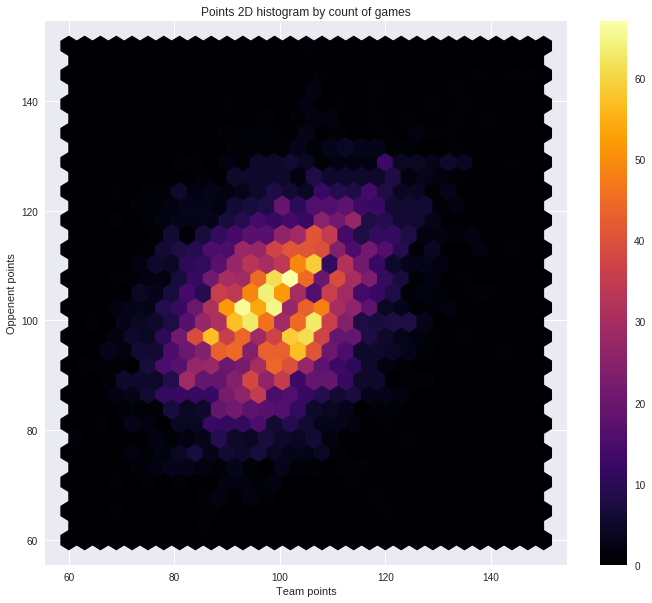

In [373]:
pl.figure(figsize=[11.7,10])
hb = pl.hexbin(df['points'], df['opponent_points'], gridsize=30, cmap='inferno', extent=[60, 150, 60, 150])
pl.xlabel('Team points')
pl.ylabel('Oppenent points')
pl.title('Points 2D histogram by count of games')
pl.colorbar()
pl.show()

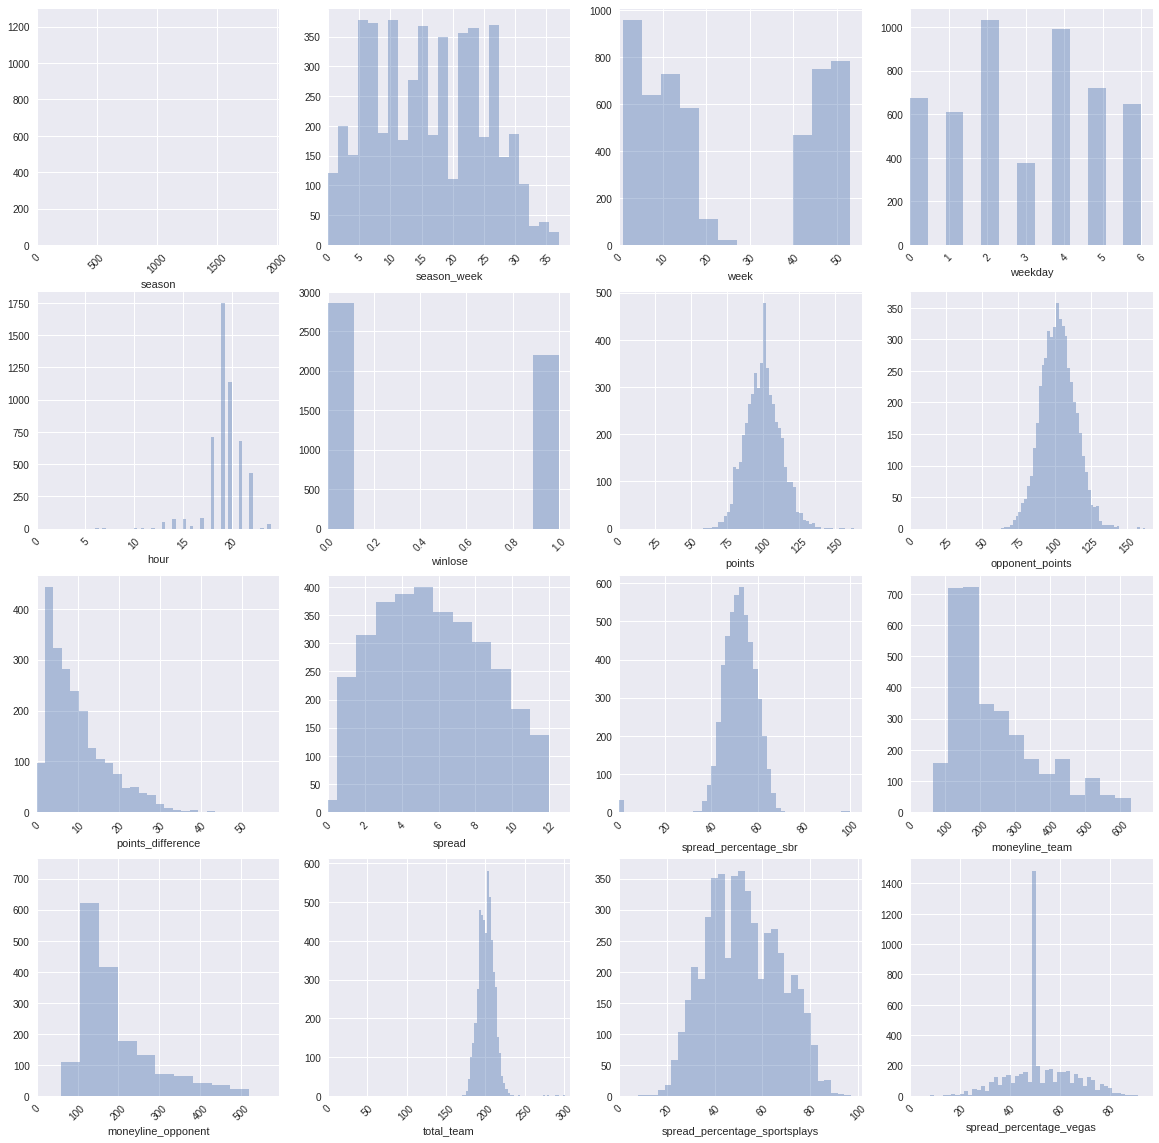

In [402]:
for i, f in enumerate(features):
    plt.subplot(4, 4,i+1)
    fig = plt.gcf()
    fig.set_size_inches(20,20)
    sns.distplot(df[f], kde=False)
    plt.xlim(0)
    plt.xticks(rotation=45)
plt.show()

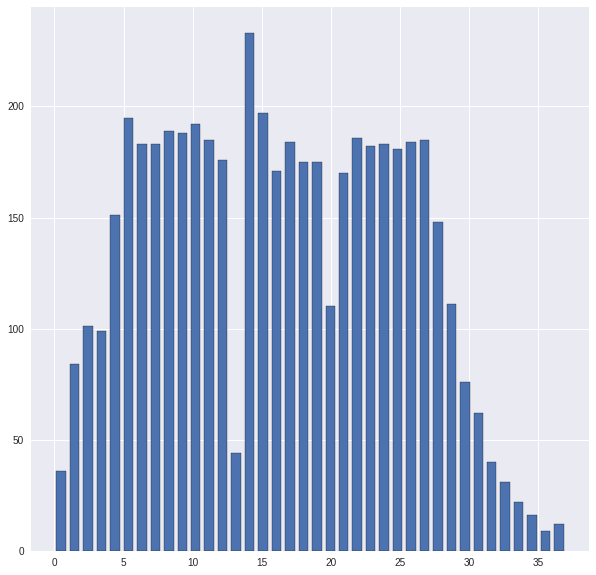

In [405]:
season_week = np.array(df['season_week'])
pl.figure(figsize=[10,10])
n, bins, patches = pl.hist(season_week, bins=len(set(df.season_week)), edgecolor='black', rwidth=0.7)
pl.grid(True)
pl.show()

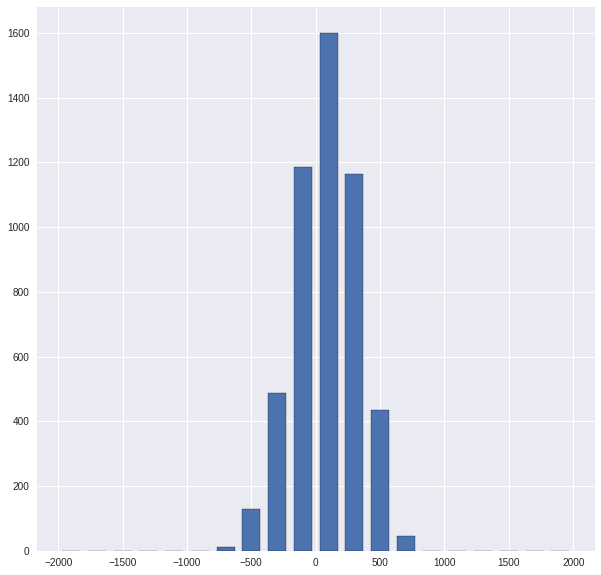

In [225]:
moneyline_team = np.array(df['moneyline_team'])
pl.figure(figsize=[10,10])
n, bins, patches = pl.hist(moneyline_team, bins=20, edgecolor='black', rwidth=0.7, range=(-2000, 2000))
pl.grid(True)
pl.show()

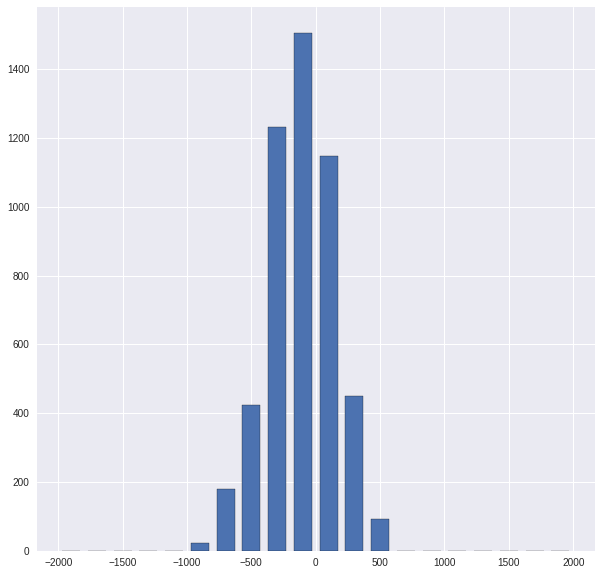

In [226]:
moneyline_opponent = np.array(df['moneyline_opponent'])
pl.figure(figsize=[10,10])
n, bins, patches = pl.hist(moneyline_opponent, bins=20, edgecolor='black', rwidth=0.7, range=(-2000, 2000))
pl.grid(True)
pl.show()

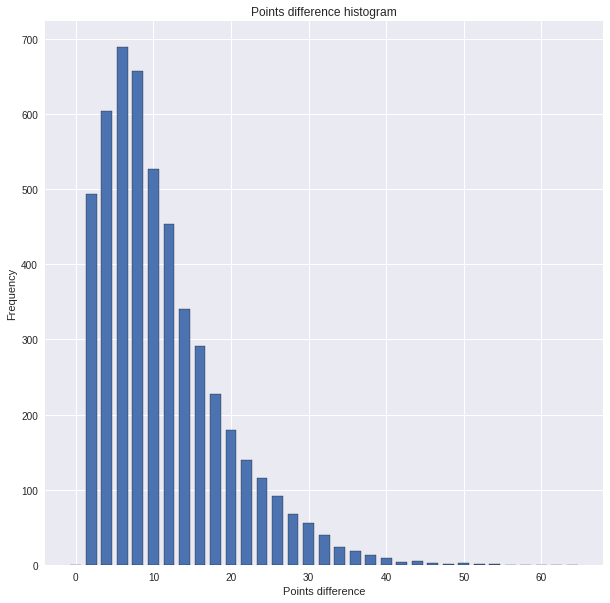

In [227]:
pts_diff = np.array(df['points_difference'])
pts_diff = np.abs(pts_diff)[pts_diff!=0]
pl.figure(figsize=[10,10])
n, bins, patches = pl.hist(pts_diff, bins=33, edgecolor='black', range=(-1, 65), rwidth=0.7)
pl.title('Points difference histogram')
pl.xlabel('Points difference')
pl.ylabel('Frequency')
# pl.xticks(range(-70,70,2))
pl.grid(True)
pl.show()

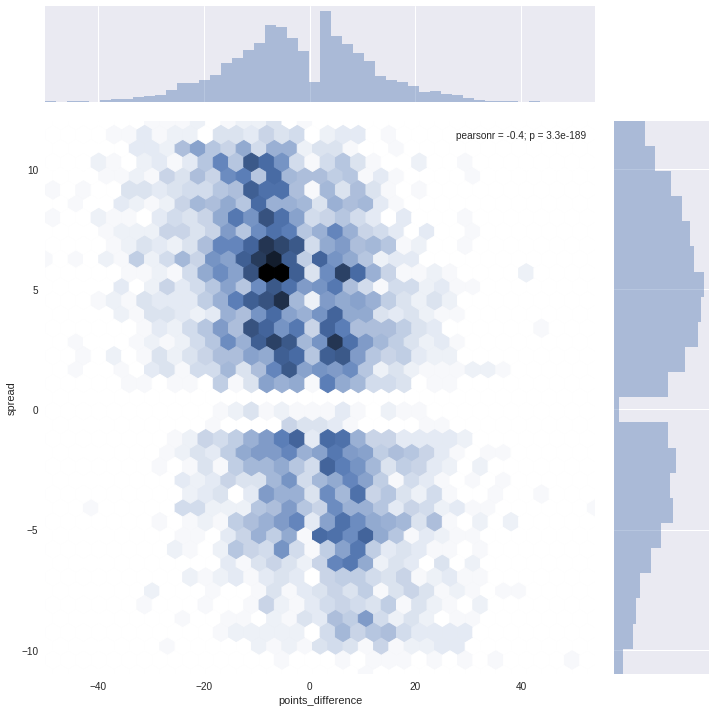

In [228]:
x = df.points_difference
y = df.spread
sns.jointplot(x=x, y=y, kind='hex', size=10)
pl.show()

## Get most similiar games

In [443]:
distance_features = ['season_week', 'spread', 'spread_percentage_sbr', 'moneyline_team',\
       'moneyline_opponent', 'total_team',\
       'spread_percentage_sportsplays',]# 'spread_percentage_vegas']

In [444]:
def get_report(_id):
    w_av =np.average(similar_games[_id].points_difference[1:], weights=similar_games[_id].distance[1:])
    print('Weighted average points_difference for simillar games', w_av)
    print('Average points_difference for simillar games', \
          np.average(similar_games[_id].points_difference[1:]))
    pl.figure(figsize=[10,10])
    x = df.points_difference
    y = df.spread
    pl.scatter(x, y, c='lightblue', s=5, )
    
    top = 20
    x1 = similar_games[_id].points_difference
    y1 = similar_games[_id].spread
    pl.scatter(x1[:top], y1[:top], c='red', s=10)
    plt.xlim(-50,  40)
    plt.ylim(-20, 30)
    pl.xlabel('Points difference')
    pl.ylabel('Spred')
    pl.title('Show on the scatter the nearest games to the given game of 2017 season NCAA Basketball (id {})'.format(_id))
    pl.show()
    return w_av

In [435]:
def get_confidence(_id, w_av):
    top = 75
    return sqrt(np.sum((similar_games[_id].points_difference[1:top] - w_av)**2, axis=0)  / (top - 2))

In [436]:
def get_similar_games(games, top=1000):
    dists = pairwise_distances(games)
    result = []
    for d in dists:
        args = d.argsort()
        similar_games = df.iloc[args[:top]]
        similar_games.insert(0, 'distance', d[args[:top]])
        result.append(similar_games)
    return result

In [445]:
def get_crossval_score(season=2016, top=30):
    games = []
    for game in similar_games:
        if game.iloc[0].season == season:
            games.append(game)
    pos = 0
    for game in games:
        year = game.iloc[0].year
        week = game.iloc[0].week
        tmp1 = game[np.logical_and(game.year <= year,\
                                   game.week <= week)]
        weighted_av = np.average(tmp1.points_difference[1:top])#, weights=tmp1.distance[1:top])
#         if top > len(tmp1):
#             print(top, len(tmp1))
        if np.sign(weighted_av) == np.sign(tmp1.points_difference.iloc[0]):
            pos += 1
    return pos / len(games)

In [446]:
scaler = MinMaxScaler()
scaled_features = scaler.fit_transform(np.array(df[distance_features].values))
similar_games1 = get_similar_games(scaled_features)
similar_games2 = get_similar_games(df[distance_features].values)
#try to use standard scaler for columns with +- values

In [447]:
similar_games = similar_games1

In [448]:
top2acc = defaultdict(lambda : [])
for year in (2014, 2015, 2016):
    for top in range(10, 101, 10):
        score = get_crossval_score(year, top)
        top2acc[top].append(score)
        print('Crossvall accuracy score {:.3f}, {:d} year, using top {:<3} closest games to compute result.'.\
              format(score, year, top))
    print()

Crossvall accuracy score 0.641, 2014 year, using top 10  closest games to compute result.
Crossvall accuracy score 0.656, 2014 year, using top 20  closest games to compute result.
Crossvall accuracy score 0.671, 2014 year, using top 30  closest games to compute result.
Crossvall accuracy score 0.660, 2014 year, using top 40  closest games to compute result.
Crossvall accuracy score 0.656, 2014 year, using top 50  closest games to compute result.
Crossvall accuracy score 0.658, 2014 year, using top 60  closest games to compute result.
Crossvall accuracy score 0.665, 2014 year, using top 70  closest games to compute result.
Crossvall accuracy score 0.667, 2014 year, using top 80  closest games to compute result.
Crossvall accuracy score 0.661, 2014 year, using top 90  closest games to compute result.
Crossvall accuracy score 0.662, 2014 year, using top 100 closest games to compute result.

Crossvall accuracy score 0.624, 2015 year, using top 10  closest games to compute result.
Crossvall

In [449]:
for top, accs in top2acc.items():
    av_acc = np.average(accs)
    print("Top {} similar games - {:.3f} average accuracy.".format(top, av_acc))

Top 10 similar games - 0.624 average accuracy.
Top 20 similar games - 0.650 average accuracy.
Top 30 similar games - 0.650 average accuracy.
Top 40 similar games - 0.653 average accuracy.
Top 50 similar games - 0.650 average accuracy.
Top 60 similar games - 0.652 average accuracy.
Top 70 similar games - 0.655 average accuracy.
Top 80 similar games - 0.656 average accuracy.
Top 90 similar games - 0.656 average accuracy.
Top 100 similar games - 0.656 average accuracy.


In [430]:
def get_similar_games2(games, games_history, metric='euclidean', top=1000):
    
    similar_games = pairwise_distances(games, games_history, n_jobs=4)
    result = []
    for d in dists:
        args = d.argsort()
        similar_games = df.iloc[args[:top]]
        similar_games.insert(0, 'distance', d[args[:top]])
        result.append(similar_games)
    
    return result

In [432]:
games = df.iloc[-3:]


,season,season_week,year,winlose,week,weekday,hour,team,opponent_team,points,...,points_difference,spread,win_against_spread,spread_percentage_sbr,moneyline_team,moneyline_opponent,total_team,total_opponent,spread_percentage_sportsplays,spread_percentage_vegas
5671,2016,16,2017,0,3,5,21,LAC,DEN,98,...,-25,5.0,0,42,175.0,-210.0,222.5,222.5,45,32
5673,2016,16,2017,0,3,6,15,LAL,DAL,73,...,-49,6.0,0,43,200.0,-240.0,207.5,207.5,48,47
5675,2016,16,2017,0,3,6,19,DEN,MIN,108,...,-3,3.5,0,46,155.0,-165.0,221.0,221.0,37,34


In [429]:
def get_pds(games, similar_games, weighted=True):
    games_history = df[features].values
    pds = []
    for game, sim_games in zip(games, similar_games):
        if weighted:
            av_pd = np.average(similar_games.points_difference[:top], weights=similar_games.distance[:top])
        else:
            av_pd = np.average(similar_games.points_difference[:top])
        pds.append(av_pd)
    return pds

In [ ]:
def get_crossval_score(season=2016, top=30):
    games = []
    for game in similar_games:
        if game.iloc[0].season == season:
            games.append(game)
    pos = 0
    for game in games:
        s = game.iloc[0].season
        season_week = game.iloc[0].season_week
        tmp1 = game[np.logical_and(game.season <= s,\
                                   game.season_week <= season_week)]
        weighted_av = np.average(tmp1.points_difference[1:top])#, weights=tmp1.distance[1:top])
#         if top > len(tmp1):
#             print(top, len(tmp1))
        if np.sign(weighted_av) == np.sign(tmp1.points_difference.iloc[0]):
            pos += 1
    return pos / len(games)